In [7]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import scipy.sparse as sparse
import scipy.linalg as linalg
import numpy as np
import collections
import copy

import amfe
from amfe.utils.utils import OrderedSet
from amfe.cyclic.cyclic import SelectionOperator, apply_cyclic_symmetry, get_all_dofs, rotate_u, set_cyclic_modes_to_component
from amfe.cyclic.cyclic import create_voigt_rotation_matrix, assemble_cyclic_modes
from amfe.linalg.arnoldi import arnoldi_iteration, inverse_arnoldi_iteration, general_inverse_arnoldi_iteration, generalized_arnoldi_iteration
from amfe.linalg.arnoldi import lanczos, is_eigvec, nullspace, LinearSys, power_iteration, ProjLinearSys, compute_modes

msh_file = r'meshes\one_eighth_disk_quad_v1.msh'


m = amfe.Mesh()
m.import_msh(msh_file)


<IPython.core.display.Javascript object>


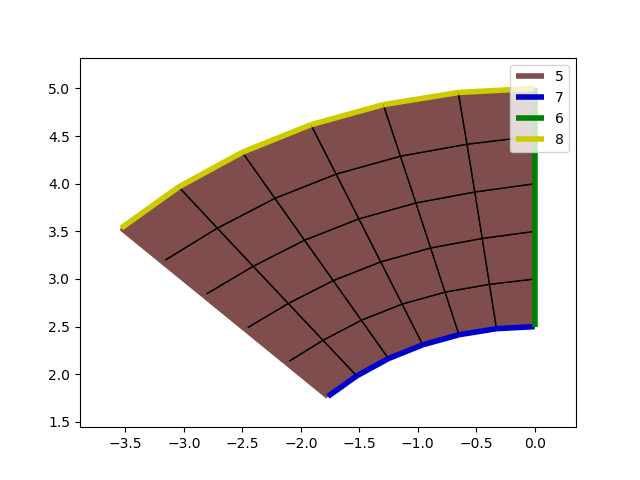

In [8]:
amfe.plot_mesh(m)

In [9]:
dirsub = m.get_submesh('phys_group', 7)

cyclic_left = m.get_submesh('phys_group', 5)
cyclic_right = m.get_submesh('phys_group', 6)
domain = m.set_domain('phys_group',9)
domain.split_in_partitions('phys_group')

from ipywidgets import interact
n = len(cyclic_right.global_node_list)-1
@interact(node_id_left=(0,n,1),node_id_right=(0,n,1)) 
def plot_nodes(node_id_left=0,node_id_right=0):
    fig, ax1 = plt.subplots(figsize=(5,5))
    amfe.plot_domain(domain,ax=ax1)
    amfe.plot_submesh(dirsub,ax=ax1,plot_1d=True)
    amfe.plot_submesh(cyclic_left,ax=ax1,plot_1d=True)
    ax1.plot(cyclic_left.get_node_coord(cyclic_left.global_node_list[node_id_left])[0],cyclic_left.get_node_coord(cyclic_left.global_node_list[node_id_left])[1],'o')
    ax1.plot(cyclic_right.get_node_coord(cyclic_right.global_node_list[node_id_right])[0],cyclic_right.get_node_coord(cyclic_right.global_node_list[node_id_right])[1],'o')

interactive(children=(IntSlider(value=0, description='node_id_left', max=5), IntSlider(value=0, description='n…

In [13]:
# creating a mechanical component
my_comp = amfe.MechanicalSystem()
my_comp.set_mesh_obj(m)
my_material = amfe.KirchhoffMaterial(E=210E9, nu=0.3, rho=7.86E3, plane_stress=True, thickness=1000.0)
my_comp.set_domain(9,my_material)
id_matrix = my_comp.assembly_class.id_matrix

# get dofs
all_dofs = get_all_dofs(id_matrix)
dir_dofs = amfe.get_dofs(dirsub, direction ='xy', id_matrix=id_matrix)

# defining sector angle
# set node diamenter
node_diam = 0
theta = np.pi/4.0 #

# creating node pairs
contact = amfe.Cyclic_Contact(cyclic_left,cyclic_right,sector_angle=theta,unit='rad',tol_radius = 1e-3)


# modifying order of nodes to have the correct node pairs for cyclic symmetry
cyclic_left.global_node_list = contact.slaves_nodes
cyclic_right.global_node_list = contact.master_nodes


superset = OrderedSet(dir_dofs)
left_dofs = OrderedSet(amfe.get_dofs(cyclic_left, direction ='xy', id_matrix=id_matrix)) - superset
right_dofs = OrderedSet(amfe.get_dofs(cyclic_right, direction ='xy', id_matrix=id_matrix)) - superset

boundary_dofs = superset | left_dofs | right_dofs
interior_dofs = list(OrderedSet(all_dofs) - boundary_dofs)
left_dofs = list(left_dofs)
right_dofs = list(right_dofs)

dof_dict = collections.OrderedDict()
dof_dict['d'] = dir_dofs 
dof_dict['r'] = left_dofs 
dof_dict['l'] = right_dofs
dof_dict['i'] = interior_dofs

s = SelectionOperator(dof_dict,id_matrix)

K, f = my_comp.assembly_class.assemble_k_and_f()
M = my_comp.assembly_class.assemble_m()
#plt.matshow(K.todense())

M_block = s.create_block_matrix(M)
M_sector = s.assemble_matrix(M,['r','l','i'])

K_block = s.create_block_matrix(K)
K_sector = s.assemble_matrix(K,['r','l','i'])


Preallocating the stiffness matrix
Done preallocating stiffness matrix with 60 elements and 84 dofs.
Time taken for preallocation: 0.00 seconds.
WARNING! This function will be deprecate. Please import this function from utils
WARNING! This function will be deprecate. Please import this function from utils
WARNING! This function will be deprecate. Please import this function from utils


In [14]:
%%time
# building cyclic matrices
beta = node_diam*theta
ej_beta_plus = np.exp(1J*beta)
M_beta = apply_cyclic_symmetry(M_block,'r','l','i',beta,theta=theta,dimension=2) 
K_beta = apply_cyclic_symmetry(K_block,'r','l','i',beta,theta=theta,dimension=2) 

n_modes = 10
eigval, V = compute_modes(K_beta,M_beta,num_of_modes=n_modes)
#eigval, V = sparse.linalg.eigsh(K_beta, k=n_modes, M=M_beta,which='SM')

Wall time: 19.1 ms


In [15]:
eigval

array([ 1274.47254078-0.00000000e+00j,  3474.33289762+6.31329515e-13j,
        5971.08606682+8.21514488e-13j,  5978.45076172-0.00000000e+00j,
        6125.79112903-6.75849827e-13j,  9343.97370877+2.46726434e-13j,
        9365.77084042+4.23393691e-13j, 10677.28391207+4.21576887e-13j,
       11042.74013741-3.17282132e-13j, 11774.81416105+9.89996247e-13j])

In [ ]:
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
import mpl_toolkits.mplot3d as a3
from ipywidgets import interact

my_comp_list = []
n_sector = int((2.0*np.pi)/theta)
    
my_comp.u_output = []

my_comp_im = copy.deepcopy(my_comp)
m_i = my_comp_im.mesh_class.rot_z(theta,unit='rad')
my_comp_im.mesh_class = m_i

ui = assemble_cyclic_modes(s,V,node_id=node_diam,theta=theta,compute_left=True,imag=False,dimension=2)
uimag = assemble_cyclic_modes(s,-V,node_id=node_diam,theta=theta,compute_left=True,imag=True,dimension=2)

my_comp.u_output = list(ui.T)
my_comp_im.u_output = uimag

fig4,ax3 = plt.subplots(1,figsize=(5,5))
bc = np.array([-6,6])

@interact(factor=(-1.0,1.0,0.1),mode_id=(0,n_modes,1))
def plot1(factor=1.0,mode_id=1):
    ax3.clear()
    amfe.plot_system_solution(my_comp, factor=1000*factor, ax = ax3, u_id = mode_id)
    ax3.set_xlim(bc)
    ax3.set_ylim(bc)


#ax3.set_axis_off()

#factor_list = 0.2*np.sin(np.linspace(0,2*np.pi,20))
#ani = FuncAnimation(fig4,  plot1,factor_list , init_func=init,interval=10, blit=True)


In [ ]:
comp_list = []
for i in range(n_sector):
    my_comp_i = set_cyclic_modes_to_component(my_comp,s,V,sector_id=i, node_id=node_diam, theta=theta, unit='rad', dimension=2)
    comp_list.append(my_comp_i)

In [ ]:
fig5,ax5 = plt.subplots(1,figsize=(5,5))
bc = np.array([-6,6])

@interact(factor=(-1.0,1.0,0.1),mode_id=(0,n_modes,1))
def plot2(factor=1.0,mode_id=0):
    ax5.clear()
    for my_comp_i in comp_list:
        amfe.plot_system_solution(my_comp_i, factor=1000*factor, ax = ax5, u_id = mode_id)
    ax5.set_xlim(bc)
    ax5.set_ylim(bc)
